# Thinkful Unit 4- Unsupervised Learning Capstone

For my unsupervised learning capstone I took tweets from major news organizations to see how similar, or dissimilar, they might be. In this, I will clean the data, tokenize it, prepare it with Bag of Words and TF-IDF. Then, I will use unsupervised methods like KMeans Clustering, and Latent Semantic Analysis (LSA) to analyze the data, before using classifiers to determine how alike the tweets are, and if the news agencies are actually reporting similar information, through correlation matrices.

In [74]:
#initial imports
import tweepy
import numpy as np
import pandas as pd
import json
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#SpaCy
import spacy
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV
#BeautifulSoup and NLTK
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords # Import the stop word list
import nltk
from nltk.corpus import stopwords

In [2]:
#My API keys are here.

str

#### Let's double check everything went through properly.

In [3]:
user = api.me()
print (user.name)

datatf


#### Yep! Good to go. Let's pick the Twitter handles we'll analyze.

In [4]:
handles = ['CNN','FoxNews','NPR','Reuters','WSJ','NYTimes', 'USATODAY', 'washingtonpost', 'BBCWorld']

#### We'll make some JSON files to store the tweets in to create a dataframe. 

In [5]:
#Open a blank .json file for each author, will append tweets later
for handle in handles:
    with open(f'/Users/tiffanyfrench/Desktop/Capstone/{handle}2.json', 'w') as f:
        try: 
            json.load(f)
        except ValueError:
            empty = [] #Just added this line to handle exceptions, does nothing

In [6]:
#Twitter's API only allows for 200 records per call
TWEETS_PER_CALL = 200 

def save_tweets(screen_nm, tweets):
    # 'a' appends to the .json we wrote with 'w' above
    with open(f'/Users/tiffanyfrench/Desktop/Capstone/{screen_nm}2.json', 'a') as f:
        for tweet in tweets:
            json.dump([tweet.text, screen_nm], f); f.write('\n')

def get_tweets(screen_nm, desired_ct):
    
    #desired_ct is the number of tweets the user wants to include
    tweet_list = []

    #grab the current maximum tweet id for provided screen name, which will be the id of the first tweet stored in the object
    curr_max_id = api.user_timeline(screen_name = screen_nm)[0].id 
    
    #may have to do more than 1 call to the API (if user wants > TWEETS_PER_CALL tweets)
    remaining = desired_ct
        
    while remaining > 0:
        tweets = api.user_timeline(screen_name = screen_nm, count = min(remaining, TWEETS_PER_CALL), max_id = curr_max_id, include_rts=False)
        
        #save these tweets in a json file for later, in case kernel crashes or want to reference at a later date
        save_tweets(screen_nm, tweets)
        
        for tweet in tweets:
            tweet_list.append([tweet.text, screen_nm])
                
        remaining = remaining - min(remaining, TWEETS_PER_CALL)
        
        #re-set the maximum id for every TWEETS_PER_CALL tweets, so that we don't include duplicate tweets
        curr_max_id = tweets[-1].id 

    return tweet_list

In [7]:
#Create tweet lists
cnn = get_tweets('CNN', 3200)
fox = get_tweets('FoxNews', 3200)
reuters = get_tweets('Reuters', 3200)
npr = get_tweets('NPR', 3200)
nyt = get_tweets('NYTimes', 3200)
wsj = get_tweets('WSJ', 3200)
usa = get_tweets('USATODAY', 3200)
wapo = get_tweets('washingtonpost', 3200)
bbc = get_tweets('BBCWorld', 3200)

In [8]:
#Combine all tweets into 1 list

full_tweets = []
for handle in handles:
    with open('/Users/tiffanyfrench/Desktop/Capstone/{}2.json'.format(handle)) as f: 
        full_tweets.append([json.loads(line) for line in f])
        

all_tweets = []
for auth in full_tweets:
    all_tweets.extend(auth[:2500])
    
#Store in dataframe
df = pd.DataFrame(all_tweets, columns = ['Tweets', 'Org'])

In [9]:
df.tail(10)

,Tweets,Org
22490,India unveils the world's tallest statue https...,BBCWorld
22491,Court acquits Christian woman on death row htt...,BBCWorld
22492,Vatican embassy: Human remains found at Rome p...,BBCWorld
22493,"Brazil: Bolsonaro plans threaten Amazon, say e...",BBCWorld
22494,Is the Amazon facing new dangers? https://t.co...,BBCWorld
22495,Dutch language besieged by English at the unis...,BBCWorld
22496,Pittsburgh shooting: First of 11 funerals held...,BBCWorld
22497,Father of 'Jihadi Jack' asks Canada to help br...,BBCWorld
22498,Canada's last witch trials: Women accused of f...,BBCWorld
22499,James 'Whitey' Bulger: The gangster who terror...,BBCWorld


In [10]:
#Checked to see how many tweets were from each organization. I dropped the AP because they had too few after RT's were 
#removed. Now, we'll just see the first 2,500 from each org, because they all had at least that many.
df.groupby(['Org']).count()

,Tweets
Org,
BBCWorld,2500
CNN,2500
FoxNews,2500
NPR,2500
NYTimes,2500
Reuters,2500
USATODAY,2500
WSJ,2500
washingtonpost,2500


### Alright! We have our tweets. It looks like there are about 22,500 for us to train on. This should be a great start. First, let's clean and tokenize to prep for unsupervised learning.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 3 columns):
Tweets             22500 non-null object
Org                22500 non-null object
MiniBatchLabels    22500 non-null int32
dtypes: int32(1), object(2)
memory usage: 439.5+ KB


In [64]:
df.Tweets.map(lambda x: len(x)).max()

138

In [65]:
df.Tweets.map(lambda x: len(x)).min()

0

In [67]:
df.Tweets.map(lambda x: len(x)).mean()

86.90697777777778

In [11]:
df.sample(10)

,Tweets,Org
1339,House Speaker Nancy Pelosi’s name was just put...,CNN
19993,A triple-amputee military vet raises $2.5 mill...,washingtonpost
9239,Karen Peetz to retire from Wells Fargo board h...,Reuters
15286,Drug-sniffing dogs scoured the terminals for a...,USATODAY
1095,"""5 eyes. 5 arms. 4 legs. All American.""\n\nRet...",CNN
8596,Super Bowl fans may have to go without guacamo...,Reuters
7215,https://t.co/v4bPtm6l9T,NPR
5563,Three ex-Credit Suisse bankers arrested in Lon...,NPR
1045,Former North Korean diplomat writes open lette...,CNN
5697,The Trump administration more than doubled the...,NPR


### Prep for CountVectorizer

#### Gets rid of numbers, urls and turns into lowercase

In [75]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def clean_tweet(raw_tweet):
    # 1. Remove HTML
    soup = BeautifulSoup(raw_tweet)
    souped = soup.get_text()
    #
    # 2. Remove non-letters        
    #letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    #
    # 3. Convert to lower case, split into individual words
    lower_case = letters_only.lower()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    #return( " ".join( meaningful_words ))   
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
for i in df:
    for i in range(len(df)):
        df['Tweets'][i] = clean_tweet(df['Tweets'][i])

In [70]:
df.sample(100)

,Tweets,Org,MiniBatchLabels
18541,marriott hackers accessed more than million pa...,washingtonpost,0
12198,advertisers including td ameritrade and ihop h...,WSJ,0
7276,from how much does murphy brown star candice b...,NPR,1
6400,with very few airfields paved roads or availab...,NPR,0
15198,massachusetts teen don lutes jr who is a colle...,USATODAY,1
16587,storing the remains often the remnants of miss...,USATODAY,0
7968,china and slow growth may keep the punchbowl b...,Reuters,8
5963,for people with disabilities like autism watch...,NPR,0
2335,five ways to avoid germs while traveling,CNN,0
11254,china s bid to rein in surging levels of corpo...,WSJ,8


In [15]:
type(df)

pandas.core.frame.DataFrame

### Splitting this up for later classifiers

In [16]:
y = df.Org
X = df.Tweets

In [17]:
y_train, y_test = train_test_split(y, test_size=0.25, random_state=42)

## Bag of Words Analysis

### BoW with SKLearn CountVectorizer

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
bow = vectorizer.fit_transform(X)
print(vectorizer.get_feature_names())

['aaa', 'aaliyah', 'aapl', 'aaron', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abaya', 'abb', 'abbas', 'abbe', 'abbi', 'abbvie', 'abby', 'abc', 'abdel', 'abdicate', 'abdicated', 'abdicates', 'abdomen', 'abduct', 'abducted', 'abduction', 'abdul', 'abdulaziz', 'abdullah', 'abdulwahab', 'abe', 'abel', 'abenomics', 'abhishek', 'abidi', 'abiding', 'ability', 'abiy', 'abkhazia', 'able', 'abloh', 'abo', 'aboard', 'abolish', 'abolished', 'abomination', 'aboriginal', 'aborted', 'abortion', 'abortions', 'abou', 'abound', 'abraham', 'abrams', 'abridged', 'abroad', 'abrupt', 'abruptly', 'absence', 'absences', 'absent', 'absentee', 'absolute', 'absolutely', 'absolve', 'absorbency', 'absorbing', 'absti', 'abstract', 'absurd', 'absurdity', 'abu', 'abundantly', 'abundez', 'abus', 'abuse', 'abused', 'abusers', 'abuses', 'abusing', 'abusive', 'abuzz', 'ac', 'aca', 'academi', 'academic', 'academy', 'acc', 'acce', 'accede', 'accelerated', 'accelerating', 'accelerator'

In [19]:
X_train, X_test= train_test_split(bow, test_size=0.25, random_state=42)

In [20]:
X_train.shape

(16875, 21569)

In [21]:
bow.shape

(22500, 21569)

In [22]:
X_test.shape

(5625, 21569)

### Models to test initial Bag of Words

In [23]:
import time

start = time.time()

rfc = ensemble.RandomForestClassifier()
fit = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.9896888888888888

Test set score: 0.4983111111111111
Done in 7.718484163284302 seconds


In [24]:
# Logistic Regression Classifier
start = time.time()
lr = LogisticRegression()
lr.fit(X_train,y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.9409185185185185

Test set score: 0.5582222222222222
Done in 1.1702508926391602 seconds


In [25]:
start = time.time()
mlp = neural_network.MLPClassifier(hidden_layer_sizes = (100,), activation = 'logistic')
train = mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)

print('Training set score:', mlp.score(X_train, y_train))
print('\nTest set score:', mlp.score(X_test, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.9993481481481481

Test set score: 0.5335111111111112
Done in 865.375659942627 seconds


### Mean Shift with Bag of Words

In [26]:
#from sklearn.cluster import MeanShift, estimate_bandwidth


# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train.todense(),quantile=0.2, n_samples=500)

# Declare and fit the model.
#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
#ms.fit(X_train.todense())

# Extract cluster assignments for each data point.
#labels = ms.labels_

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
#n_clusters_ = len(np.unique(labels))

#print("Number of estimated clusters: {}".format(n_clusters_))


It looks like Bag of Words might be doing a better job of distinguishing between the tweets. We have 9 accounts, and 8 clusters. That seems pretty good!

### K Means with Bag of Words

In [27]:
# Normalize the data.
X_norm = normalize(X_train)

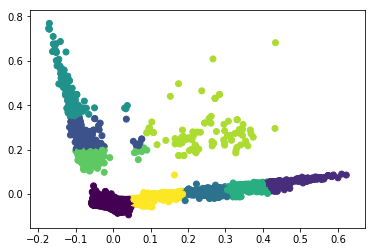

In [28]:
# Reduce it to two components.
X_pca_bow = PCA(2).fit_transform(X_norm.todense())

# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=42).fit_predict(X_pca_bow)

# Plot the solution.
plt.scatter(X_pca_bow[:, 0], X_pca_bow[:, 1], c=y_pred)
plt.show()

### Kmeans MiniBatch

In [29]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

true_k = 10
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', batch_size=5000)

km.fit(X_train_norm)
km_train_label = km.labels_
km_test_label = km.predict(X_test_norm)
true_k = 10
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', batch_size=5000)

km.fit(X_train_norm)
km_train_label = km.labels_
km_test_label = km.predict(X_test_norm)

In [30]:
from time import time

rfc = ensemble.RandomForestClassifier()
fit = rfc.fit(X_train_norm, y_train)
y_pred = rfc.predict(X_test_norm)

print('Training set score:', rfc.score(X_train_norm, y_train))
print('\nTest set score:', rfc.score(X_test_norm, y_test))
t0 = time()
print("Done in %0.3fs" % (time() - t0))

Training set score: 0.9910518518518519

Test set score: 0.5253333333333333
Done in 0.000s


In [35]:
# Logistic Regression Classifier
import time
start = time.time()
lr = LogisticRegression()
lr.fit(X_train_norm,y_train)

print('Training set score:', lr.score(X_train_norm, y_train))
print('\nTest set score:', lr.score(X_test_norm, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.7367111111111111

Test set score: 0.5116444444444445
Done in 0.6629791259765625 seconds


### LSA with BoW

In [36]:
start = time.time()
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=5,n_iter=500)
lsa.fit(bow)
terms = vectorizer.get_feature_names()
X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.transform(X_test)

for i,comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    sortedterms = sorted(termsInComp, key=lambda x: x[1],reverse=True)[:10]
    print("Concept %d:" % i)
    for term in sortedterms:
        print(term[0])
    print(" ")
end = time.time()
print("Done in", end - start, "seconds")

Concept 0:
trump
president
new
border
wall
year
says
shutdown
house
government
 
Concept 1:
new
year
york
old
city
eve
people
day
world
man
 
Concept 2:
year
old
man
christmas
time
boy
woman
girl
killed
best
 
Concept 3:
government
shutdown
partial
federal
house
says
day
senate
workers
end
 
Concept 4:
says
president
china
house
people
just
white
leader
sen
man
 
Done in 17.609925985336304 seconds


In [37]:
fit = rfc.fit(X_train_lsa, y_train)
y_pred = rfc.predict(X_test_lsa)

print('Training set score:', rfc.score(X_train_lsa, y_train))
print('\nTest set score:', rfc.score(X_test_lsa, y_test))


Training set score: 0.9877333333333334

Test set score: 0.36746666666666666


### Bigrams

In [38]:
handles = ['CNN','FoxNews','NPR','Reuters','WSJ','NYTimes', 'USATODAY', 'washingtonpost', 'BBCWorld']

In [39]:
X_train_clean, X_test_clean= train_test_split(X, test_size=0.25, random_state=42)
count_vect_bigram = CountVectorizer(ngram_range=(1,2))
train_data_bow_bigram = count_vect_bigram.fit_transform(X_train_clean)
test_data_bow_bigram = count_vect_bigram.transform(X_test_clean)

Training set score: 0.9980444444444444

Test set score: 0.6229333333333333
Cross-Valid Bigram Fold Results are:  [0.60283688 0.60106383 0.61242604 0.61315166 0.60130332 0.59193357
 0.58635015 0.62551929 0.62077151 0.62589074]
Mean of Folds are =  0.6081246977504331
Done in %0.3fs 62.98772597312927


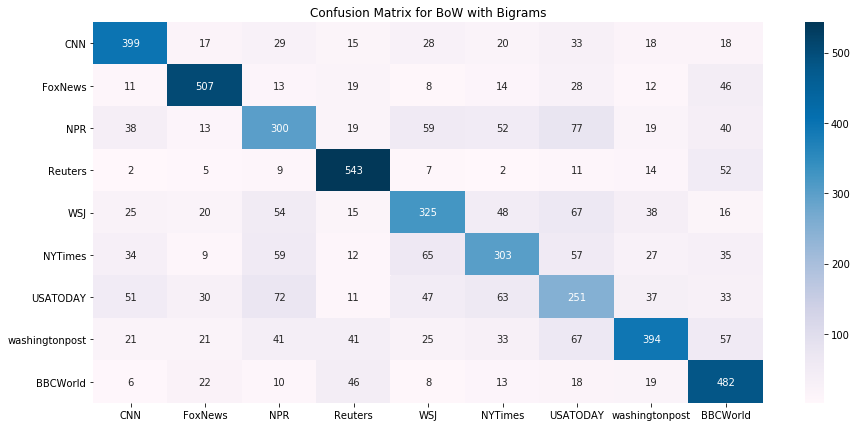

In [40]:
import time
start = time.time()

#Confusion matrix for Bigram BOW with Logistic Regression

lr = LogisticRegression()
lr.fit(train_data_bow_bigram,y_train)

print('Training set score:', lr.score(train_data_bow_bigram, y_train))
print('\nTest set score:', lr.score(test_data_bow_bigram, y_test))

y_pred = lr.predict(test_data_bow_bigram)

conf = confusion_matrix(y_test, y_pred, labels = handles)

cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
plt.title('Confusion Matrix for BoW with Bigrams')
sns.heatmap(cm, annot=True, cmap="PuBu", fmt = 'd')
crs = cross_val_score(lr, train_data_bow_bigram, y_train, cv=10)
print("Cross-Valid Bigram Fold Results are: ",crs)
print("Mean of Folds are = ",crs.mean())
end = time.time()
print("Done in %0.3fs", end - start)

### Bigrams outperformed LSA and BoW with KMeans. Let's see what TF-IDF can do...

## TF-IDF Analysis

### Train and Test Sets

In [41]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)
tfidf.shape

(22500, 21569)

In [42]:
X_train_tfidf, X_test_tfidf = train_test_split(tfidf, test_size=0.25, random_state=42)

In [43]:
import time

start = time.time()

rfc = ensemble.RandomForestClassifier()
fit = rfc.fit(X_train_tfidf, y_train)
y_pred = rfc.predict(X_test_tfidf)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.9904

Test set score: 0.5192888888888889
Done in 8.067336797714233 seconds


In [44]:
# Logistic Regression Classifier
start = time.time()
lr = LogisticRegression()
lr.fit(X_train_tfidf,y_train)

print('Training set score:', lr.score(X_train_tfidf, y_train))
print('\nTest set score:', lr.score(X_test_tfidf, y_test))
end = time.time()
print("Done in", end - start, "seconds")

Training set score: 0.7979851851851851

Test set score: 0.5335111111111112
Done in 0.9050681591033936 seconds


### Mean Shift with TF-IDF

In [45]:
#from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
#bandwidth = estimate_bandwidth(tfidf.todense(), quantile=0.2)

# Declare and fit the model.
#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
#ms.fit(X_train_tfidf.todense())

# Extract cluster assignments for each data point.
#labels = ms.labels_

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
#n_clusters_ = len(np.unique(labels))

#print("Number of estimated clusters: {}".format(n_clusters_))

### K Means Clustering with TF-IDF

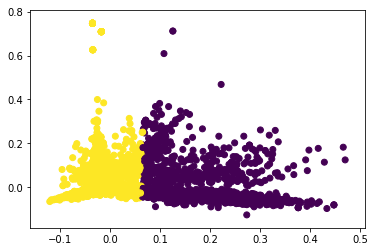

Done in %0.3fs 81.61351108551025


In [46]:
start = time.time()
# Normalize the data.
X_normt = normalize(tfidf)
# Reduce it to two components.
X_pcat = PCA(2).fit_transform(X_normt.todense())

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pcat)

# Plot the solution.
plt.scatter(X_pcat[:, 0], X_pcat[:, 1], c=y_pred)
plt.show()
end = time.time()
print("Done in %0.3fs", end - start)

In [47]:
start = time.time()
rfc = ensemble.RandomForestClassifier()

vectorizer1 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=2, # only use words that appear at least 2x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vectorizer1.fit_transform(X_train_clean)
X_test_tfidf = vectorizer1.transform(X_test_clean)

fit = rfc.fit(X_train_tfidf, y_train)
y_pred = rfc.predict(X_test_tfidf)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))
end = time.time()
print("Done in %0.3fs", end - start)

Training set score: 0.9892740740740741

Test set score: 0.5160888888888889
Done in %0.3fs 4.138273000717163


In [48]:
start = time.time()
X = df['Tweets']
X_norm_tfidf = normalize(vectorizer1.fit_transform(X))

true_k = 10
labels = y
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', batch_size=5000)

print("Clustering sparse data with %s" % km)
km.fit(X_norm_tfidf)
mini_labels = km.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, km.labels_, sample_size=5000))
end = time.time()
print("Done in %0.3fs", end - start)

Clustering sparse data with MiniBatchKMeans(batch_size=5000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Homogeneity: 0.029
Completeness: 0.043
V-measure: 0.034
Adjusted Rand-Index: 0.005
Silhouette Coefficient: 0.006
Done in %0.3fs 1.3573808670043945


In [49]:
df['MiniBatchLabels'] = mini_labels

In [50]:
for label in set(mini_labels):
    print('Cluster: %d' % label)
    print(df[df.MiniBatchLabels == label].groupby('Org').count())
    print('')

Cluster: 0
                Tweets  MiniBatchLabels
Org                                    
BBCWorld          1770             1770
CNN               1198             1198
FoxNews           1632             1632
NPR               1505             1505
NYTimes           1443             1443
Reuters           1565             1565
USATODAY          1509             1509
WSJ               1489             1489
washingtonpost    1290             1290

Cluster: 1
                Tweets  MiniBatchLabels
Org                                    
BBCWorld           126              126
CNN                275              275
FoxNews            201              201
NPR                257              257
NYTimes            303              303
Reuters            137              137
USATODAY           361              361
WSJ                271              271
washingtonpost     184              184

Cluster: 2
                Tweets  MiniBatchLabels
Org                                    
BBCWo

In [51]:
#Let's check Cluster 0 - the largest, and likely a catch-all for tweets that did not fall into other clusters
shuffle(df[df.MiniBatchLabels == 0]).head(10)

,Tweets,Org,MiniBatchLabels
19237,steelers defensive coordinator is planning for...,washingtonpost,0
19500,the probability of one hitting earth remains v...,washingtonpost,0
16240,kevin spacey fowler will be doing a perp walk ...,USATODAY,0
5261,what s that smell it s the country s billion p...,NPR,0
14374,some travelers are using dating apps like grin...,NYTimes,0
22312,paris ambulances snail protest brings city roa...,BBCWorld,0
5444,in lois weber became the first american woman ...,NPR,0
21395,a simple flu a simple infection can wipe out y...,BBCWorld,0
19449,ruth bader ginsburg released from hospital aft...,washingtonpost,0
4193,charlottesville suspect attacked in jail offic...,FoxNews,0


In [52]:
#Let's check Cluster 1
shuffle(df[df.MiniBatchLabels == 1]).head(10)

,Tweets,Org,MiniBatchLabels
18462,don lemon delivers an emotional message to kev...,washingtonpost,1
5073,canada has granted asylum to rahaf mohammed al...,NPR,1
5820,this year s dramatic percent drop in californi...,NPR,1
4894,we need to come together and we need to assure...,FoxNews,1
10189,it s not you it s who you know to break into t...,WSJ,1
2600,on midterms overall i think that democrats had...,FoxNews,1
22070,armistice day remembrance events around world ...,BBCWorld,1
20565,kevin spacey actor charged with sexual assault...,BBCWorld,1
7617,samsung warns of big profit slide see more fro...,Reuters,1
7464,update in late morning trading the dow jones w...,NPR,1


In [53]:
#Cluster 2
shuffle(df[df.MiniBatchLabels == 2]).head(10)

,Tweets,Org,MiniBatchLabels
6943,patricio manuel the first openly transgender m...,NPR,2
2346,the two sailors had been stranded on their boa...,CNN,2
14472,after years a music school for the blind is be...,NYTimes,2
369,the co owner of a south korean revenge porn si...,CNN,2
21649,guatemalan former soldier sentenced to more th...,BBCWorld,2
13071,divorces initiated by women had doubled in the...,NYTimes,2
16296,only one photo was shared with a simple captio...,USATODAY,2
5739,a man who says he is the brother of u s citize...,NPR,2
21206,carla stefaniak man held in us tourist s death...,BBCWorld,2
12620,for the last several years astronomers have be...,NYTimes,2


### LSA with TF-IDF

Let's see how many features we had in our TF-IDF training set.

In [54]:
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

Number of features: 11137


In [55]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space to about 10% of the original.
svd= TruncatedSVD(2100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of tweets our solution considers similar, for the first five identified topics
tweets_by_component=pd.DataFrame(X_train_lsa, index=list(X_train))
for i in range(5):
    print('Component {}:'.format(i))
    print(tweets_by_component.loc[:,i].sort_values(ascending=False)[0:10])
import time
print(time.time())

Percent variance captured by all components: 68.8251176734203
Component 0:
  (0, 2152)\t1\n  (0, 3874)\t1\n  (0, 14610)\t1\n  (0, 14682)\t1\n  (0, 16793)\t1\n  (0, 16998)\t1\n  (0, 19906)\t1\n  (0, 20849)\t1                                                      0.543719
  (0, 12798)\t1\n  (0, 14682)\t1\n  (0, 16012)\t1\n  (0, 19906)\t1\n  (0, 21447)\t1                                                                                                       0.457470
  (0, 2152)\t1\n  (0, 8149)\t1\n  (0, 11440)\t1\n  (0, 17443)\t1\n  (0, 18053)\t1\n  (0, 19906)\t1\n  (0, 20849)\t1                                                                       0.455799
  (0, 690)\t1\n  (0, 4986)\t1\n  (0, 5620)\t1\n  (0, 9088)\t1\n  (0, 12798)\t1\n  (0, 14682)\t1\n  (0, 16549)\t1\n  (0, 19906)\t1\n  (0, 20849)\t1\n  (0, 21384)\t1                       0.453047
  (0, 2152)\t1\n  (0, 5730)\t1\n  (0, 7700)\t1\n  (0, 8149)\t1\n  (0, 12013)\t1\n  (0, 14682)\t1\n  (0, 17443)\t1\n  (0, 19423)\t1\n  (0, 19906)\

In [56]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=5,n_iter=500)
lsa.fit(tfidf)
terms = vectorizer.get_feature_names()

for i,comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    sortedterms = sorted(termsInComp, key=lambda x: x[1],reverse=True)[:10]
    print("Concept %d:" % i)
    for term in sortedterms:
        print(term[0])
    print(" ")

Concept 0:
trump
president
border
shutdown
wall
government
new
house
year
says
 
Concept 1:
new
year
day
know
need
briefing
old
york
start
morning
 
Concept 2:
shutdown
government
know
need
day
briefing
morning
start
end
partial
 
Concept 3:
government
shutdown
partial
federal
new
workers
year
longest
senate
pay
 
Concept 4:
wall
street
look
journal
page
border
early
mexico
year
emergency
 


In [57]:
#Try a GBM classifier here, using TF-IDF 

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_tfidf, y_train)
tfidf_pred = clf.predict(X_test_tfidf.toarray())

print('Training set score:', clf.score(X_train_tfidf.toarray(), y_train))
print('\nTest set score:', clf.score(X_test_tfidf.toarray(), y_test))

Training set score: 0.5506962962962964

Test set score: 0.4177777777777778


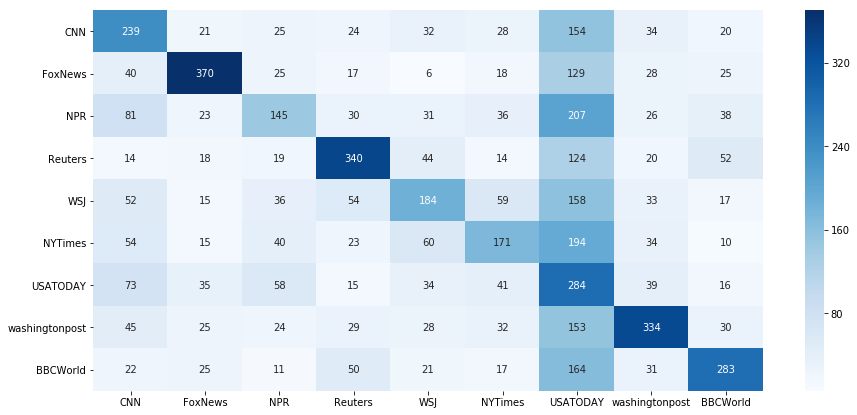

In [58]:
#Confusion matrix for GBM performance visualization on TF-IDF

conf = confusion_matrix(y_test, tfidf_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

In [59]:
X_train_tfidf.shape

(16875, 11137)

In [60]:
#LSA with Tf-idf
mlp = neural_network.MLPClassifier(hidden_layer_sizes = (100,), activation = 'logistic')
train = mlp.fit(X_train_lsa, y_train)
mlp_y_pred = mlp.predict(X_test_lsa)

print('Training set score:', mlp.score(X_train_lsa, y_train))
print('\nTest set score:', mlp.score(X_test_lsa, y_test))

Training set score: 0.8094222222222223

Test set score: 0.4839111111111111


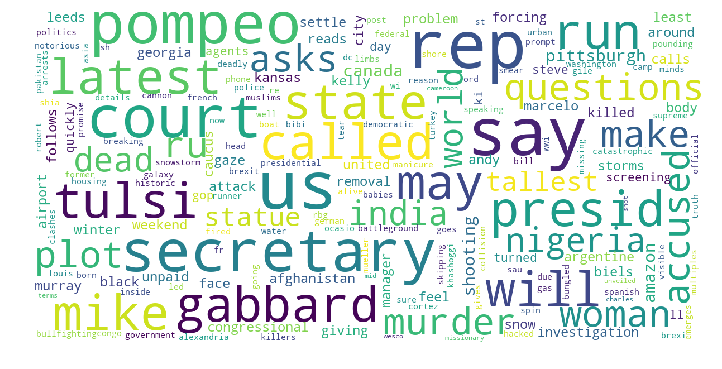

In [61]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df.Tweets)